### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [232]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3

wordcloud 1.8.0
"""
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re


############ CONSTANTS ##################################

DATASET_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATASET_TAR_FILE_NAME = "aclImdb_v1.tar.gz"
CLEAN_DATA_FILE = "IMDB_clean_data.csv"

DATASET_FOLDER = "imdb_dataset"
IMDB_FOLDER_NAME = "imdb"

DATA_SET_IMDB = DATASET_FOLDER+"/"+IMDB_FOLDER_NAME+"/"

COUNTER_FITTED_VECTORS = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

# sentiment analysis training hyperparameters
DIMENSION = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 20
MODEL_SAVE_PATH = "../models/imdb_model.hdf5"


# DATA SPLIT & VOCABULARY SIZE i.e. use 75% for training and 25% for test
TRAINING_SPLIT = 0.75

# dataset has been downloaded, if you want to download a clean dataset set this to False
DATASET_DOWNLOADED = False

### Dataset download and extracton functions

In [233]:
import os
import requests 
import tarfile
import shutil


def extract_tar_file(file_path: str, destination_folder: str):
    
    if not os.path.exists(file_path):
        print("tar file ",file_path, " not found!")
    else:
        print("\nExtracting file, please wait...")
        my_tar = tarfile.open(file_path)
        my_tar.extractall(destination_folder) # specify which folder to extract to
        my_tar.close()
        os.remove(file_path) # after extracting the contents, delete the tar file
        print("File extracted in folder: ",destination_folder )
    

    
    
def download(url: str, dest_folder: str):
       
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split('/')[-1].replace(" ", "_")  # be careful with file names 
    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("Downloading file ", filename, ", please wait ...")
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024): # set chunk size of 1MB (can reduce or increase depending on memory available) 
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
        print("Download complete!")
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))
   

        
def get_directory_name(path):
    
    dir_list = []
    for file in os.listdir(path):
        if os.path.isdir(os.path.join(path, file)):
            if file[0] != '.':
                dir_list.append(file)
    return dir_list

         
    
    
def rename_folder(from_folder: str, to_folder: str):  
    
    os.rename(from_folder, to_folder)
    

        

# Download the dataset

In [234]:
#DATASET_DOWNLOADED = False  # uncomment this line if you want to download a fresh copy of the dataset

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
else:
    DATASET_DOWNLOADED = True
    download(DATASET_URL, dest_folder=DATASET_FOLDER)
    
    




Download complete!


# Extract the contents of the tar file

In [ ]:

TAR_FILE_PATH = DATASET_FOLDER+"/"+DATASET_TAR_FILE_NAME # where to extract the contents

extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)



Extracting file, please wait...


# Rename the folder to IMDB_FOLDER_NAME

In [203]:
directories_in_dataset_folder = get_directory_name(DATASET_FOLDER)

from_folder =""
to_folder = DATASET_FOLDER+"/"+IMDB_FOLDER_NAME

if len(directories_in_dataset_folder) == 1:
    from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
    rename_folder(from_folder, to_folder)
else:
    print("ERROR!")
    print(DATASET_FOLDER," folder has too many sub directories!")


# Process dataset
### Read the dataset file and return a data frame


In [205]:
def process_dataset_IMDB(file_path: str):
    """
    Need to redo this to deal with the IMDB dataset - rename columns to match the sentiments140 dataset so we can 
    re-use all th e below methods without changing anything
    """

    
    pos_train = file_path + "train/pos"
    pos_train_files = [pos_train + '/' + x for x in os.listdir(pos_train) if x.endswith('.txt')]
   
    pos_test = file_path + "test/pos"
    pos_test_files = [pos_test + '/' + x for x in os.listdir(pos_test) if x.endswith('.txt')]
    
    # list containing the file path to all positive sentiment text
    all_pos = pos_train_files + pos_test_files
    
    
    neg_train = file_path + "train/neg"
    neg_train_files = [neg_train + '/' + x for x in os.listdir(neg_train) if x.endswith('.txt')]
    
    neg_test = file_path + "test/neg"
    neg_test_files = [neg_test + '/' + x for x in os.listdir(neg_test) if x.endswith('.txt')]
    
    # list containing the file path to all negative sentiment text
    all_neg = neg_train_files + neg_test_files
    
    df_pos = pd.DataFrame(columns = ['sentiment', 'text'])
    for i, l in enumerate(all_pos):
            f = open(all_pos[i])
            line = f.readline()
            df_pos = df_pos.append({'sentiment': 1, 'text': line}, ignore_index=True)
            f.close()
    
    df_neg = pd.DataFrame(columns = ['sentiment', 'text'])
    for i, l in enumerate(all_neg):
            f = open(all_neg[i])
            line = f.readline()
            df_neg = df_neg.append({'sentiment': 0, 'text': line}, ignore_index=True)
            f.close()
    
    print("neg shape: ", df_neg.shape)
    print("pos shape: ", df_pos.shape)
    frames = [df_neg, df_pos]
    data_file = pd.concat(frames, axis=0)
    
    return data_file 
    
    

### Read in the dataset file and show the first 5 rows of the data frame


In [206]:
data_frame  = process_dataset_IMDB(DATA_SET_IMDB)

#data_frame = process_dataset_Sentiment140(DATA_SET_TWITTER)
data_frame.head()

neg shape:  (25000, 2)
pos shape:  (25000, 2)


,sentiment,text
0,0,"I found the documentary entitled Fast, Cheap, ..."
1,0,This is an embarrassment to everyone and every...
2,0,"The cast although nothing special, all do an O..."
3,0,Investigative reporter Darren McGavin (as Carl...
4,0,This movie is horrible. Everything in it has b...


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

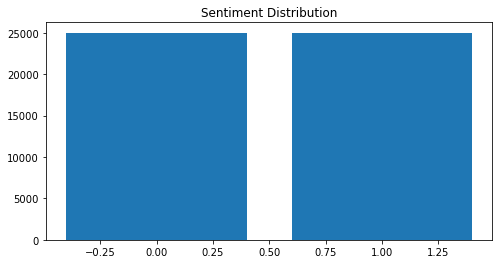

In [36]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

In [37]:
print(val_count)

1    25000
0    25000
Name: sentiment, dtype: int64


# Functions to clean dataset, remove hyperlinks, html entities, punctuation and newline characters etc ..

In [207]:

"""
preprocess-twitter.py

Script for preprocessing tweets by Romain Paulus

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

Extended by Manjinder Singh, to enable removal of html entities, and punctuation symbols (except the apostophe)
"""
FLAGS = re.MULTILINE | re.DOTALL

# additional html entities added to remove (Manjinder Singh)
html_entities = [" quot ", " amp ", " lt ", " gt ", " circ ", " tilde ", " ensp ", " emsp ", " thinsp ", " zwnj ", " zwj ", 
                     " lrm ", " rlm ", " ndash ", " mdash ", " lsquo ", " rsquo ", " sbquo ", " ldquo ", " rdquo ", " bdquo ", " permil ", " lsaquo ", " rsaquo "]

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return  result

def allcaps(text):
    text = text.group()
    return text.lower() # removed tag


def tokenize(text):
    
    punctuation = string.punctuation
    punctuation = punctuation.translate({ord(i):None for i in "'"}) # keep the apostrophe
       
    # lower case all text
    text = text.lower()
    # remove extra spaces so we can then remove all amp and quot chars correctly, also removes trailing spaces
    text = ' '.join(text.split()) 
    
    
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "") # url
    text = re_sub(r"@\w+", "") # twitter username
    text = re_sub(r"&\w+", "") # remove html entities starting with a &
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "") # smile
    text = re_sub(r"{}{}p+".format(eyes, nose), "") # lolface
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "") # sadface
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "") # neutralface
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","") # heart
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "") # remove numbers
    text = re_sub(r"#\w+", "")  # remove hashtag
    text = re_sub(r"([!?.]){2,}", r"\1 ") # remove punctuation repetitions eg. "!!!" 
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 ") # remove elongated words and trim eg. shorten 'Awwwwwwwww' to 'Aw'
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    #text = re_sub(r" ([A-Z]){2,} ", allcaps) # lowercase all caps
    
    
    # finally remove all punctuation and numbers
    text  = "".join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]+', '', text)
    
    # remove all html entities
    for h in html_entities:
        if h in text:
            text = re_sub(h, "")
    

    return text.lower()

from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
        
    def handle_data(self, d):
        self.text.write(d)
        
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


### Use the regex to clean all our text entries and write back to the data frame

In [208]:
data_frame.text = data_frame.text.apply(lambda x: strip_tags(x))
data_frame.text = data_frame.text.apply(lambda x: tokenize(x))


# save the cleaned dataset
data_frame.to_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE, index = False)

In [209]:
# clean data file
data_frame.head()

,sentiment,text
0,0,i found the documentary entitled fast cheap ...
1,0,this is an embarrassment to everyone and every...
2,0,the cast although nothing special all do an o...
3,0,investigative reporter darren mcgavin as carl ...
4,0,this movie is horrible everything in it has b...


# Wordcloud of ```positive``` sentiments

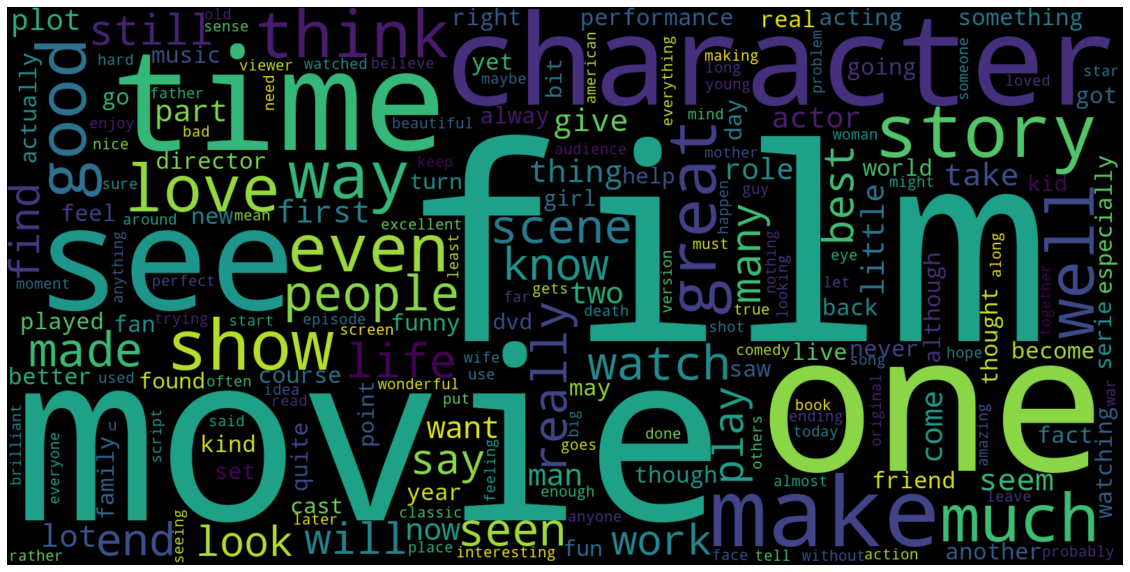

In [41]:


plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Wordcloud of ```negative``` sentiments

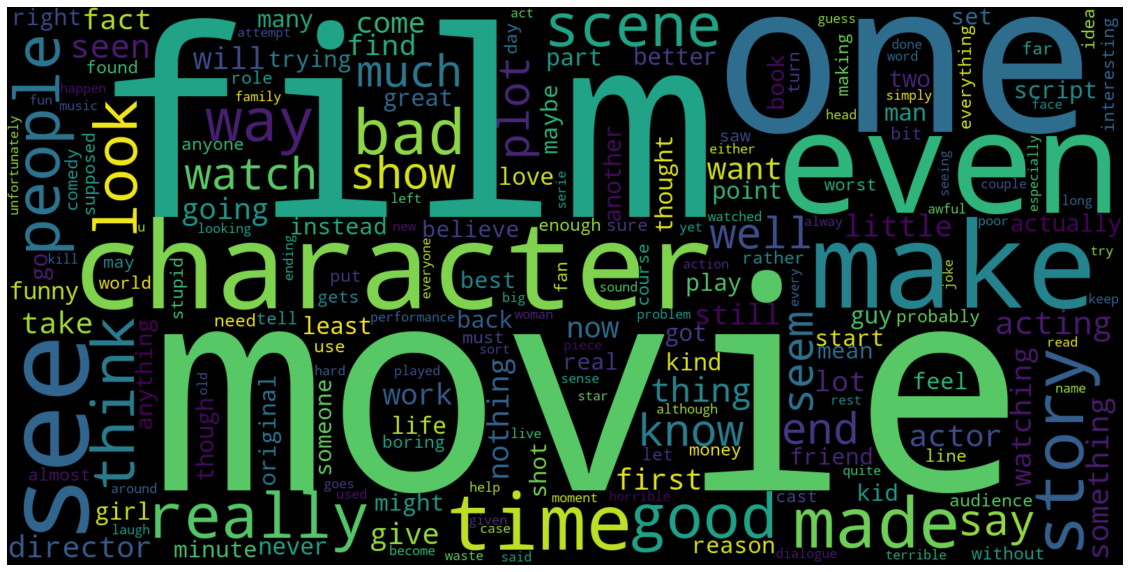

In [42]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Now we need randomise the dataset

In [215]:

data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 


In [216]:
data_frame.head()

,sentiment,text
13147,0,after kenneth opel's rousing story of the invi...
839,0,oh where to begin the cinematography was grea...
10377,0,just emailed a friend who's in film school abo...
14649,1,long trailer whoever said that has got to be ...
6951,1,even though it has one of the standard revenge...


### Now we split the data set into ```TRAINING_SPLIT``` for training and ```(1 - TRAINING_SPLIT)``` for testing
#### This will also shuffle the data set before splitting it

In [217]:
train_data, test_data = train_test_split(data_frame, test_data= (1 - TRAINING_SPLIT), random_state = 7)

In [221]:
print("Training Data:\t",len(train_data), " data points\t", TRAINING_SPLIT * 100,"%")
print("Test Data:\t",len(test_data), " data points\t", (1 - TRAINING_SPLIT) * 100 ,"%")

Training Data:	 37500  data points	 75.0 %
Test Data:	 12500  data points	 25.0 %


### Examine the training and test data sets

#### Training dataset

In [222]:
train_data.head()

,sentiment,text
24643,0,i used to think that it couldn't get worse tha...
19796,1,this b film reached the spartan movie house of...
19424,1,james stewart plays dr ben mckenna who with...
17230,0,the initiation to the local sport team involve...
23023,1,changi has a delightfully fresh script acted ...


#### Testing dataset

In [223]:
test_data.head()

,sentiment,text
22829,0,first off the initial concept of a lost fortu...
10006,0,i have yet to read a negative professional rev...
13030,1,i can't count the times i have watched this a...
10528,1,having heard quite positive reviews and having...
1370,0,celia johnson is good as the nurse michael ho...




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [224]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post'



In [225]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_data.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index



# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
train_sequences = tokenizer.texts_to_sequences(train_data.text)
test_sequences = tokenizer.texts_to_sequences(test_data.text)

# Get max training and test sequence length and find the maximum value to use for padding
# dataset has a longer sequence - we don't want it truncated)
"""
To ensure that all our sequences are of the same length, we need to set the 
maxlen hyperparameter. Here we set it to twice the maximum length found in
our training dataset sequences.
"""

maxlen_test = max([len(x) for x in train_sequences])
maxlen_train = max([len(x) for x in train_sequences])

# set to max of the two values from the training and test sets
maxlen = max(maxlen_test,maxlen_train)

# make sure maxlen is divisible by BATCH_SIZE
while True:
    if (maxlen % BATCH_SIZE) != 0:
        maxlen += 1
    else:
        break

# Pad the training and test sequences
"""
The encoded sequences need to be the same length. 

We use the maxlen found above to set this length. This will 
pad all other sequences with extra '0's at the end ('post').
"""
train_x = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)
test_x = pad_sequences(test_sequences, padding=pad_type, maxlen=maxlen)


# Check results of tokenization and creation of training and test sequences

In [226]:

print("Padded Training Shape:", train_x.shape,"\n")
print("maxlen (maximum length of training sequences):", maxlen)


print("\nExample Training Sequences:\n",train_sequences[1])
print("\nExample Padded Training Sequences:\n",train_x[0])

print("\n##################################################################\n")

print("Padded Testing Shape:", test_x.shape,"\n")
print("maxlen (maximum length of test sequences):", maxlen)

print("\nExample Testing sequences:\n",test_sequences[5])
print("\nExample Padded Testing Sequences:\n",test_x[9])



Padded Training Shape: (37500, 2240) 

maxlen (maximum length of training sequences): 2240

Example Training Sequences:
 [11, 721, 19, 3783, 2, 34035, 17, 329, 5, 55, 66592, 1977, 41, 1806, 98, 90, 749, 8, 142, 479, 73, 5, 249, 9368, 209, 2401, 11188, 34, 10092, 34036, 50996, 244, 36, 11, 17, 3227, 37, 4, 37766, 9, 66, 68, 15301, 16, 5447, 22759, 42960, 14, 4963, 145, 267, 9, 573, 36, 46, 5, 2, 1675, 1831, 69, 8, 190, 5561, 7988, 66593, 18, 85, 13, 11, 66594, 442, 16, 15302, 5, 42961, 6, 118, 12, 29, 2, 58, 8, 100, 406, 55, 504, 135, 66, 15303, 950, 3380, 5, 7326, 20799, 37, 12, 9369, 4565, 1025, 311, 6538, 4679, 170, 5103, 150, 299, 10, 127, 37767, 8981, 29, 2, 11611, 2359, 201, 2, 4486, 10246, 9, 59, 235, 26, 39, 155, 66595, 209, 18, 91, 155, 17, 12, 279, 66, 68, 8, 9498, 54, 51, 17218, 2, 3932, 1380, 5155, 17219, 567, 55, 540, 145, 180, 2089, 3, 4487, 957, 34, 46, 42962, 6199, 1578, 3, 42963, 7882, 135, 214, 26, 46, 302, 12095, 12, 160, 1504, 2178, 2172, 778, 22760, 1119, 6, 68, 11,

# Print the first entry only, to show the actual text as a padded sequqnce

In [227]:
for x, y in zip(test_data.text, test_x):
    print('{} \n\n -- to padded sequence --> {}'.format(x, y))
    break

first off  the initial concept of a lost fortune in gold bars discovered in a new zealand lake  inside a downed world war plane is a great opening  what follows is nothing but cartoon like drivel  men chasing men  cars chasing men  helicopters chasing men  helicopters chasing boats  boats chasing boats  for the better part of an hour  the most boring nonsense  with absolutely no advancement to the story  special mention must be made of the chop shop editing  as many scenes seem to have been spliced together in random order  the acting by all concerned is an embarrassment  one last thing  the picture quality and sound quality is so bad on this dvd that you will be appalled   merk 

 -- to padded sequence --> [ 86 125   2 ...   0   0   0]


### There are only two labels in our model (0 = negative, 1 = positive)

In [228]:
print(train_data.sentiment.unique().tolist())


[0, 1]


#### Encode training labels using scikit-learn module sklearn.preprocessing.LabelEncoder

In [54]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

train_y = encoder.transform(train_data.sentiment.to_list())
test_y = encoder.transform(test_data.sentiment.to_list())
# print("Dimensions before reshape: ",train_y.ndim)

# convert the 1 dimensional array into a 2d array as required for training 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# print("Dimensions after reshape: ",train_y.ndim)
print("train_y shape:", train_y.shape)
print("test_y shape:", test_y.shape)


train_y shape: (40000, 1)
test_y shape: (10000, 1)


# Word-Embeddings
#### Word embeddings is a feature vector for each of the words that enbales us to give words a ```context```.
- Instead of creating this ourselves, we will use a pre-trained embddings vectors (GloVe Embeddings)

# DATA FILE LOCATIONS
- DATA_SET_TWITTER = "dataset/train.csv"
- COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
- GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

# Functions to:
- #### Create and return an embeddings model as a dictionary ```def load_embeddings_model(embeddings_file: str) -> dict:```
- #### Create and return an embeddings matrix ```def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension=300) -> np.ndarray:```
- #### Save a numpy array to file ```def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):```

In [55]:
MAX_VOCABULARY_SIZE = len(tokenizer.word_index) + 1

    
def load_embeddings_model(embeddings_file: str) -> dict:
    embeddings_model= {}
    
    print("Loading embeddings model to dictionary, please wait...")
    with open(embeddings_file, 'r', encoding="utf8") as f:
        for line in f:
            values = line.strip().split(' ')
            word = value = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_model[word] = coefs

    print("Finished!")
    print('Found %s word vectors in model.' %len(embeddings_model))
    return embeddings_model
    
def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension: int) -> np.ndarray:
    
    # load a pre-trained embeddings model into a dictionary
    embeddings_model = load_embeddings_model(embeddings_file)
    
    print("\nCreating embeddings matrix ...")
    embedding_matrix = np.zeros((max_vocabulary_size, dimension))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print("Finished!")        
    return embedding_matrix
    
def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):
    
    print("Saving file please wait...")
    full_path_to_file = full_path_to_file+"_%d.npy" % max_vocabulary_size
    np.save(full_path_to_file,npy_array) 
    print("Finished!")
    print("Saved file to: ",full_path_to_file)
    
    


# Create embeddings matrix of words found in Twitter dataset

In [56]:

glove_embeddings_matrix  = get_embeddings_matrix(GLOVE_EMBEDDINGS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of GloVe embeddings matrix

In [57]:

print(glove_embeddings_matrix.shape)


(139121, 300)


### Save GloVe Embeddings Matrix to file

In [58]:

# save glove embeddings for words found to the embedding directory
full_path_to_file = "embeddings/imdb_glove_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, glove_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_glove_embeddings_139121.npy


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [59]:

counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [60]:

print(glove_embeddings_matrix.shape)


(139121, 300)


### Save our vocabulary embeddings matrix

In [61]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/imdb_counter_fitted_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_counter_fitted_embeddings_139121.npy


# Check we have a GPU available for traiing the model
#### (If no GPU available then training will be done using the CPU, which is very slow!)

In [62]:
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.gpu_device_name(): 
    print('GPU Device used for training will be: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU, make sure using a GPU enabled machine, or check you have GPU version of Tensorflow")

Number of GPUs available:  1
GPU Device used for training will be: /device:GPU:0


# Train the sentiment analysis model

In [230]:


# get the saved GloVe embeddings matrix
glove_embeddings_matrix = np.load(("embeddings/imdb_glove_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))


In [231]:
from  manny_train import models

model_test = models.TrainModel(glove_embeddings_matrix,
                                train_x, train_y, test_x, test_y,
                                epochs=1,
                                batch_size=BATCH_SIZE,
                                input_dim=MAX_VOCABULARY_SIZE,
                                input_length=maxlen,
                                trainable=True,
                                output_dim=DIMENSION,
                                learning_rate=LEARNING_RATE
                               )

Building model, please wait ...

Training on GPU...


ValueError: Data cardinality is ambiguous:
  x sizes: 37500
  y sizes: 40000
Please provide data which shares the same first dimension.

# Generate our embedding layer for model training

In [64]:

batch_size = BATCH_SIZE
lstm_size = 128
num_epochs = EPOCHS
vocabulary_size = glove_embeddings_matrix.shape[0]

print(batch_size)
print(num_epochs)


64
20


In [ ]:

embedding_layer = tf.keras.layers.Embedding(input_dim=MAX_VOCABULARY_SIZE,
                                          output_dim=DIMENSION,
                                          weights=[glove_embeddings_matrix],
                                          input_length=maxlen,
                                          trainable=False)
    

In [ ]:

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:

sequence_input = Input(shape=(maxlen,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='tanh')(x)
x = Bidirectional(LSTM(64, dropout=0.2))(x)
x = Dense(512, activation='tanh')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()


# Triain the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


In [ ]:
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")


In [ ]:
# Model.fit(
#     x=None,
#     y=None,
#     batch_size=None,
#     epochs=1,
#     verbose=1,
#     callbacks=None,
#     validation_split=0.0,
#     validation_data=None,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
#     steps_per_epoch=None,
#     validation_steps=None,
#     validation_batch_size=None,
#     validation_freq=1,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
# )

# BATCH_SIZE = 64
# EPOCHS = 20

history = model.fit(train_x, train_y, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1,
                    validation_data=(test_x, test_y), 
                    callbacks=[ReduceLROnPlateau])

# Evaluate the model

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
s.show()

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(test_x, verbose=1, batch_size=BATCH_SIZE)
y_predictions = [decode_sentiment(score) for score in scores]


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()



In [ ]:
print(classification_report(list(test_data.sentiment), y_predictions))

# Save the model
we can later load it from disk

In [ ]:
from keras.models import load_model

model.save('../models/imdb_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('../models/imdb_model.h5')

In [ ]:
# model.summary(line_length=None, positions=None, print_fn=None)
# model.get_weights()
# model.get_config()
model.summary()
test_x[0]

In [ ]:
import pickle
# save history as a dictionary in case we need to plot again later
with open('../models/trainHistoryDictIMDB.dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# history = pickle.load(open('/trainHistoryDict'), "rb")

In [ ]:

history_dict = pickle.load(open('../models/trainHistoryDictIMDB.dict', 'rb') )


In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [93]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'epochs' is not defined

<Figure size 432x288 with 0 Axes>

In [229]:
from  manny_train import models

model_test = models.TrainModel(glove_embeddings_matrix,
                                train_x, train_y, test_x, test_y,
                                epochs=1,
                                batch_size=BATCH_SIZE,
                                input_dim=MAX_VOCABULARY_SIZE,
                                input_length=maxlen,
                                trainable=True,
                                output_dim=DIMENSION,
                                learning_rate=LEARNING_RATE
                               )

Building model, please wait ...

Training on GPU...


ValueError: Data cardinality is ambiguous:
  x sizes: 37500
  y sizes: 40000
Please provide data which shares the same first dimension.

In [89]:
# save these to a file and then we can retrieve and work with them later
# add save methods to the class
hist = model_test.get_history
model = model_test.get_model

In [90]:
history_dict = model_test.history_dict
model = model_test.model

In [92]:
#model.summary()
print(history_dict.history)
model.summary()

{'loss': [0.4945707619190216], 'accuracy': [0.7550250291824341], 'val_loss': [0.2709681987762451], 'val_accuracy': [0.8909000158309937], 'lr': [0.001]}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2496)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2496, 300)         41736300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 2496, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2492, 64)          96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512) 